<h3>Setup</h3>

In [1]:
# Libraries
import torch
import sys
import platform


# MacOs
if platform.system() == "Darwin":
    main_dir = './'
    data_dir = '../data/'
    weights_dir = '../weights/'
    
    #device = 'cpu'
    device = 'mps' if torch.backends.mps.is_available()  else 'cpu'
    
    print(f"System: MacOs\nDevice: {device}\nMain_dir: {main_dir}")

# Linux
elif platform.system() == "Linux" and 'google.colab' not in sys.modules:
    main_dir = './'
    data_dir = '../data/'
    detector_weights_dir = '../weights/'
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"System: Linux\nDevice: {device}\nMain_dir: {main_dir}")

# Colab
elif platform.system() == "Linux" and 'google.colab' in sys.modules:
    !pip install pytesseract
    from google.colab import drive
    
    drive.mount('/content/drive')
    
    main_dir = '/content/drive/MyDrive/Università/Artificial Intelligence and Robotics/1° Anno/2° Semestre/Vision and Perception/Project/'
    data_dir = 'data/'
    detector_weights_dir = 'weights/'
    
    sys.path.insert(0, main_dir)
    sys.path.insert(1, main_dir+'src/')
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    print(f"System: Colab\nDevice: {device}\nMain_dir: {main_dir}")

# Unknown
else:
    print("System unknown")


System: MacOs
Device: mps
Main_dir: ./


<h3>Prepare datasets and loaders</h3>

In [2]:
from modules import dataset

PREPARE_CSV = False
PLOT_STATS = False

In [3]:
if PREPARE_CSV: 
    df = dataset.xml2csv(main_dir=main_dir, path_folder=data_dir)
    df.head()

In [4]:
train_ds, valid_ds = dataset.get_datasets(data_dir=main_dir+data_dir, csv_file='dataset.csv')

In [5]:
if PLOT_STATS: dataset.dataset_stats(dataset=train_ds)

/Users/valeriospagnoli/Library/Python/3.9/lib/python/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


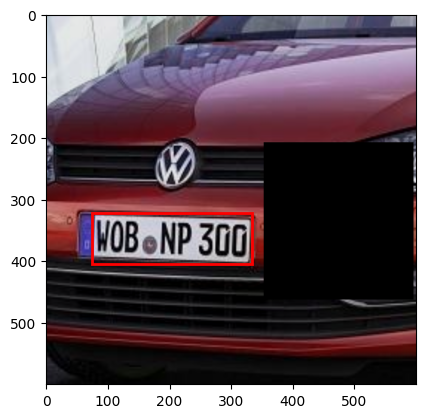

In [6]:
dataset.plot_image_from_dataset(dataset=train_ds, idx=0)

In [7]:
train_dl, valid_dl = dataset.get_dataloaders(train_ds=train_ds, valid_ds=valid_ds, batch_size=8)

<h3>Training</h3>

In [8]:
TRAIN_MODEL=False
LOAD_MODEL=False

In [9]:
if TRAIN_MODEL:
    from modules import model, training
    
    detector = model.get_plateDetectorModel(num_classes=3, feature_extraction=True)
    if LOAD_MODEL:
        detector.load_state_dict(torch.load(main_dir+weights_dir+'detector_weights/detector.pt'))

    optimizer = torch.optim.SGD([p for p in detector.parameters() if p.requires_grad],
                                lr = 0.005,
                                momentum = 0.9,
                                weight_decay = 0.0005)
    
    losses = training.training_and_validation(model=detector.to(device),
                                                optimizer=optimizer,
                                                num_epochs=50,
                                                train_loader=train_dl,
                                                valid_loader=valid_dl,
                                                device=device,
                                                weights_dir=main_dir+weights_dir+'detector_weights/',
                                                verbose=2)
    
    training.plot_losses(train_epoch_losses=losses[0], valid_epoch_losses=losses[1])

<h3>Inference</h3>

In [10]:
from modules import inference, real_time_object_detector

COMPUTE_ONE_IMAGE = False
COMPUTE_REAL_TIME_OBJECT_DETECTOR = True
FRAMES_TO_VIDEO = False

In [11]:
if COMPUTE_ONE_IMAGE: 
    import cv2
    detector = inference.load_model_for_inference(weights_file=main_dir+weights_dir+'detector_weights/detector.pt', device=device)
    cv2_vehicles_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(0,0,255), 'thickness':2, 'lineType':cv2.LINE_AA}
    cv2_plates_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.5, 'color':(255,0,0), 'thickness':2, 'lineType':cv2.LINE_AA}
    real_time_object_detector.plot_one_image(model=detector, 
                                            img_param=data_dir+'test/TEST_2.jpeg', 
                                            sr_weights_path=weights_dir+'edsr_weights/EDSR_x3.pb', 
                                            cv2window=False, 
                                            cv2imshow=False, 
                                            plt_plot=True, 
                                            cv2_vehicles_cfg=cv2_vehicles_cfg, 
                                            cv2_plates_cfg=cv2_plates_cfg)

In [12]:
if COMPUTE_REAL_TIME_OBJECT_DETECTOR: 
    import cv2
    detector = inference.load_model_for_inference(weights_file=main_dir+weights_dir+'detector_weights/detector.pt', device=device)
    cv2_vehicles_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.8, 'color':(0,0,255), 'thickness':2, 'lineType':cv2.LINE_AA}
    cv2_plates_cfg = {'fontFace':cv2.FONT_HERSHEY_SIMPLEX, 'fontScale':0.8, 'color':(255,0,0), 'thickness':2, 'lineType':cv2.LINE_AA}
    velocity_cfg = {'line1': 1025, 'line2': 1205, 'meters_line1line2':7.5, 'fps':25}
    real_time_object_detector.real_time_object_detector(model=detector, 
                                                        video_path=data_dir+'test/Video_1.mp4', 
                                                        sr_weights_path=weights_dir+'edsr_weights/EDSR_x3.pb',
                                                        velocity_cfg=velocity_cfg,
                                                        cv2_vehicles_cfg=cv2_vehicles_cfg, 
                                                        cv2_plates_cfg=cv2_plates_cfg,
                                                        new_frame_folder=main_dir+'../output_video/')

Folder './../output_video/' already exist.


In [ ]:
if FRAMES_TO_VIDEO:
    from modules.real_time_object_detector import frames2video
    frames2video(images_folder=main_dir+'../output_video/', output_video_path=main_dir+'../output_video/',  original_video_path=data_dir+'test/Video_1.mp4')